# Домашнее задание 2
Подобрать оптимальные признаки и обучить модель с наименьшей RMSE для yield strength (tensile strength) на 5-fold CV.

### Подготовка датасета и утилит
- Датасет steel_strength (matminer)
- Разбиение формулы на состав
- Получение свойств по составу (magpie)

### Исследование значимых свойств
- Обучение модели CatBoostRegressor
- Выделение важных параметров (get_feature_importance())
- Исключение незначительных параметров (порог важности 0.1)

### Обучение модели на важных свойствах
- Обучение модели CatBoostRegressor на CV=5




# Подготовка датасета и утилит

In [1]:
# ! pip install matminer
# ! pip install catboost

In [2]:
from matminer.datasets import load_dataset
from matminer.featurizers.conversions import StrToComposition
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
import matplotlib
import matplotlib.cm as cm
from catboost import CatBoostRegressor

In [5]:
def plot_diff(ytrain, ytest):
    plt.figure(figsize=(8,6))
    plt.xlabel(u'$Yield\ Strength_{exp}$')
    plt.ylabel(u'$Yeild\ Strength_{pred}$')
    c = cm.tab10(0)
    plt.scatter(ytrain, ytest, facecolors='none', edgecolors=c, s = [200]*len(ytest), linewidths=3)
    #plt.scatter(ytrain, ytest, colors=c, s = [100]*len(ytest), linewidths=3)
    plt.plot(ytrain, ytrain, '--k')
    plt.grid()
    plt.show()
    rmse = np.sqrt(mse(ytest, ytrain))
    print('RMSE = {0} '.format(rmse))
    return
def LR():
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    ypred_train = lr.predict(X_train)
    ypred_test = lr.predict(X_test)
    plot_diff(y_train, ypred_train)
    plot_diff(y_test, ypred_test)
    rmse = np.sqrt(mse(y_test, ypred_test))
    return 
def CB():
    model = CatBoostRegressor()
    model.fit(X_train, y_train,
             eval_set=(X_valid, y_valid),
             use_best_model=True, plot=True)
    ypred_train = model.predict(X_train)
    ypred_val = model.predict(X_valid)
    ypred_test = model.predict(X_test)
    
    plot_diff(y_train, ypred_train)
    plot_diff(y_valid, ypred_val)
    plot_diff(y_test, ypred_test)
    return model
def NN():
    nn = MLPRegressor(hidden_layer_sizes=(50,50,50,))
    nn.fit(X_train, y_train)
    ypred_train = nn.predict(X_train)
    ypred_test = nn.predict(X_test)
    plot_diff(y_train, ypred_train)
    plot_diff(y_test, ypred_test)
    rmse = np.sqrt(mse(y_test, ypred_test))
    return

In [3]:
df = load_dataset('steel_strength')

In [4]:
df_comp = df[df.columns[1:15]]

In [7]:
df_form = df[[df.columns[0], df.columns[14]]]

In [8]:
stc = StrToComposition()

In [9]:
df_form = stc.featurize_dataframe(df_form, 'formula')

StrToComposition:   0%|          | 0/312 [00:00<?, ?it/s]

In [10]:
from matminer.featurizers.composition import ElementProperty

In [11]:
ep = ElementProperty.from_preset('magpie')

In [12]:
df_magpie = ep.featurize_dataframe(df_form, ['composition'])

ElementProperty:   0%|          | 0/312 [00:00<?, ?it/s]

In [13]:
df_magpie = df_magpie.drop(['formula', 'composition'], axis=1)

In [14]:
df_magpie.shape

(312, 133)

In [15]:
df_magpie = df_magpie.loc[:, (df_magpie != 0).any(axis=0)] #убираем нули
df_magpie.dropna(axis=1, inplace=True) #убираем NaN
df_magpie = df_magpie.loc[:, (df_magpie != df_magpie.iloc[0]).any()] #убираем константы

In [16]:
df_magpie.shape

(312, 81)

# Исследование значимых свойств

In [17]:
X = df_magpie[df_magpie.columns[1:]]
Y = df_magpie['yield strength']

X_train_full, X_test, y_train_full, y_test = train_test_split(X, Y, shuffle=True, test_size=0.1, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, shuffle=True, test_size=0.1, random_state=42)

In [18]:
scaler = StandardScaler()
X_train_full = scaler.fit_transform(X_train_full)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.041012
0:	learn: 305.2909783	test: 216.5724396	best: 216.5724396 (0)	total: 93.3ms	remaining: 1m 33s
1:	learn: 299.2145844	test: 212.9402272	best: 212.9402272 (1)	total: 120ms	remaining: 59.8s
2:	learn: 293.5956263	test: 212.0437311	best: 212.0437311 (2)	total: 151ms	remaining: 50.1s
3:	learn: 288.7788953	test: 210.8936844	best: 210.8936844 (3)	total: 212ms	remaining: 52.7s
4:	learn: 283.4810316	test: 209.8948639	best: 209.8948639 (4)	total: 257ms	remaining: 51.1s
5:	learn: 277.9930348	test: 208.1768830	best: 208.1768830 (5)	total: 294ms	remaining: 48.7s
6:	learn: 273.3242209	test: 207.4622584	best: 207.4622584 (6)	total: 334ms	remaining: 47.3s
7:	learn: 269.5999357	test: 206.6708006	best: 206.6708006 (7)	total: 379ms	remaining: 46.9s
8:	learn: 265.0391319	test: 204.9897589	best: 204.9897589 (8)	total: 401ms	remaining: 44.2s
9:	learn: 259.9708995	test: 203.7459662	best: 203.7459662 (9)	total: 419ms	remaining: 41.5s
10:	learn: 255.4156145	test: 201.9555861	best: 2

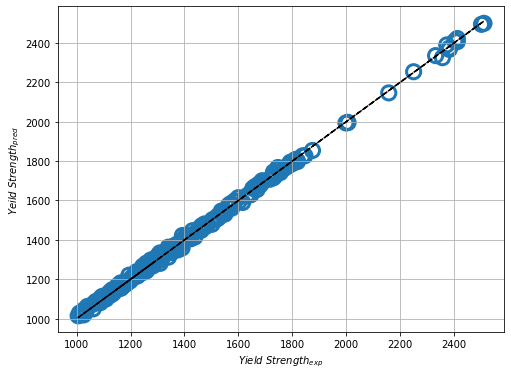

RMSE = 11.606882461197477 


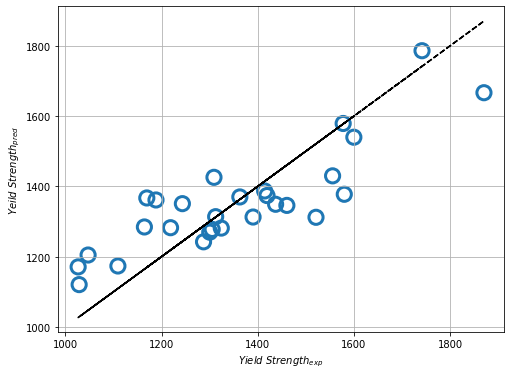

RMSE = 112.42833128387217 


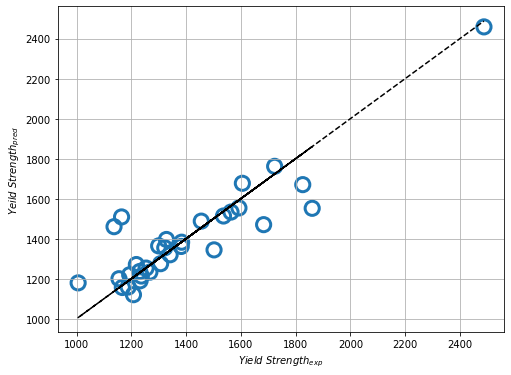

RMSE = 122.92688451377838 


In [19]:
model_cb = CB()

In [20]:
pd.DataFrame({'feature_importance': model_cb.get_feature_importance(), 
              'feature_names': X.columns}).sort_values(by=['feature_importance'])

,feature_importance,feature_names
48,0.000000,MagpieData maximum NfValence
69,0.000000,MagpieData range GSvolume_pa
49,0.000000,MagpieData range NfValence
15,0.000000,MagpieData minimum MeltingT
68,0.000000,MagpieData minimum GSvolume_pa
...,...,...
41,4.301754,MagpieData avg_dev NsValence
75,4.362610,MagpieData avg_dev GSbandgap
29,4.493595,MagpieData avg_dev Row
34,5.230575,MagpieData avg_dev CovalentRadius


In [21]:
# f stands for feature
# i stands for importance
# obtain features with importance < threshold
threshold = 0.1
negligible_features = [f for f, i in zip(X.columns, model_cb.get_feature_importance()) if i < threshold]
negligible_features

['MagpieData maximum Number',
 'MagpieData range Number',
 'MagpieData maximum MendeleevNumber',
 'MagpieData minimum AtomicWeight',
 'MagpieData maximum AtomicWeight',
 'MagpieData range AtomicWeight',
 'MagpieData minimum MeltingT',
 'MagpieData maximum MeltingT',
 'MagpieData maximum Column',
 'MagpieData minimum Row',
 'MagpieData maximum Row',
 'MagpieData range Row',
 'MagpieData minimum CovalentRadius',
 'MagpieData maximum CovalentRadius',
 'MagpieData maximum NpValence',
 'MagpieData range NpValence',
 'MagpieData maximum NfValence',
 'MagpieData range NfValence',
 'MagpieData mean NfValence',
 'MagpieData avg_dev NfValence',
 'MagpieData maximum NValence',
 'MagpieData range NValence',
 'MagpieData minimum GSvolume_pa',
 'MagpieData range GSvolume_pa',
 'MagpieData range GSbandgap']

In [22]:
df_magpie.head()

,yield strength,MagpieData minimum Number,MagpieData maximum Number,MagpieData range Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData minimum MendeleevNumber,MagpieData maximum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,...,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData maximum GSbandgap,MagpieData range GSbandgap,MagpieData mean GSbandgap,MagpieData avg_dev GSbandgap,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber
0,2411.5,6.0,42.0,36.0,26.664769,1.152116,43.0,78.0,35.0,56.377863,...,10.801999,0.447150,4.496,4.496,0.005073,0.010126,1.648909,0.572542,222.420512,9.409624
1,1123.1,6.0,74.0,68.0,26.300744,1.522817,46.0,82.0,36.0,54.768497,...,10.816101,0.410662,6.437,6.437,0.049054,0.097090,1.606402,0.628422,222.057381,11.123311
2,1736.3,13.0,42.0,29.0,26.145400,0.858372,43.0,78.0,35.0,55.653308,...,10.769147,0.303342,0.773,0.773,0.000155,0.000309,1.600877,0.637435,223.594029,8.212745
3,2487.3,6.0,42.0,36.0,26.743298,1.235479,43.0,78.0,35.0,56.227153,...,10.834815,0.488892,4.496,4.496,0.002939,0.005870,1.668280,0.561291,222.541850,9.377819
4,2249.6,6.0,42.0,36.0,26.526613,0.958219,43.0,78.0,35.0,56.375439,...,10.759185,0.355467,4.496,4.496,0.002912,0.005815,1.677256,0.551281,222.528371,9.298562


In [23]:
df_magpie_reduced = df_magpie.copy()
for feature_name in negligible_features:
  df_magpie_reduced.drop(feature_name, axis=1, inplace=True)

In [24]:
df_magpie_reduced.head()

,yield strength,MagpieData minimum Number,MagpieData mean Number,MagpieData avg_dev Number,MagpieData minimum MendeleevNumber,MagpieData range MendeleevNumber,MagpieData mean MendeleevNumber,MagpieData avg_dev MendeleevNumber,MagpieData mean AtomicWeight,MagpieData avg_dev AtomicWeight,...,MagpieData avg_dev NUnfilled,MagpieData mean GSvolume_pa,MagpieData avg_dev GSvolume_pa,MagpieData maximum GSbandgap,MagpieData mean GSbandgap,MagpieData avg_dev GSbandgap,MagpieData mean GSmagmom,MagpieData avg_dev GSmagmom,MagpieData mean SpaceGroupNumber,MagpieData avg_dev SpaceGroupNumber
0,2411.5,6.0,26.664769,1.152116,43.0,35.0,56.377863,2.437556,57.240083,2.419658,...,0.778513,10.801999,0.447150,4.496,0.005073,0.010126,1.648909,0.572542,222.420512,9.409624
1,1123.1,6.0,26.300744,1.522817,46.0,36.0,54.768497,2.013802,57.015783,3.969693,...,0.660989,10.816101,0.410662,6.437,0.049054,0.097090,1.606402,0.628422,222.057381,11.123311
2,1736.3,13.0,26.145400,0.858372,43.0,35.0,55.653308,2.290349,56.160791,1.772402,...,0.697873,10.769147,0.303342,0.773,0.000155,0.000309,1.600877,0.637435,223.594029,8.212745
3,2487.3,6.0,26.743298,1.235479,43.0,35.0,56.227153,2.327724,57.471595,2.679939,...,0.748157,10.834815,0.488892,4.496,0.002939,0.005870,1.668280,0.561291,222.541850,9.377819
4,2249.6,6.0,26.526613,0.958219,43.0,35.0,56.375439,2.360988,56.896297,1.938594,...,0.757653,10.759185,0.355467,4.496,0.002912,0.005815,1.677256,0.551281,222.528371,9.298562


# Обучение модели на важных свойствах

In [25]:
X = df_magpie_reduced[df_magpie_reduced.columns[1:]]
Y = df_magpie_reduced['yield strength']

X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.1, random_state=42)

In [26]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [30]:
model = CatBoostRegressor()


model_cv = cross_validate(model, X_train, y_train, cv=5, 
                          scoring=('r2', 'neg_mean_squared_error'),
                          return_estimator=True)

Выходные данные были обрезаны до нескольких последних строк (5000).
4:	learn: 283.9594366	total: 115ms	remaining: 22.9s
5:	learn: 280.1972632	total: 140ms	remaining: 23.2s
6:	learn: 277.0738221	total: 164ms	remaining: 23.3s
7:	learn: 272.9549102	total: 186ms	remaining: 23.1s
8:	learn: 269.9285123	total: 216ms	remaining: 23.8s
9:	learn: 266.5480334	total: 249ms	remaining: 24.6s
10:	learn: 263.2545102	total: 273ms	remaining: 24.5s
11:	learn: 259.4833008	total: 290ms	remaining: 23.9s
12:	learn: 256.2484271	total: 312ms	remaining: 23.7s
13:	learn: 254.5266659	total: 335ms	remaining: 23.6s
14:	learn: 251.9025353	total: 375ms	remaining: 24.6s
15:	learn: 249.3524598	total: 394ms	remaining: 24.2s
16:	learn: 246.9452926	total: 421ms	remaining: 24.4s
17:	learn: 244.0269899	total: 451ms	remaining: 24.6s
18:	learn: 241.3396537	total: 470ms	remaining: 24.3s
19:	learn: 238.5219949	total: 501ms	remaining: 24.6s
20:	learn: 235.6200688	total: 526ms	remaining: 24.5s
21:	learn: 232.8778413	total: 554ms	r

In [31]:
print(model_cv['test_r2'], model_cv['test_neg_mean_squared_error'])
best_estimator_id = np.argmax(np.abs(model_cv['test_r2']))

[0.76554042 0.82798741 0.55357034 0.80006434 0.74377808] [-21299.04338052 -13361.50797261 -45751.96437338 -16983.43016344
 -25961.5557845 ]


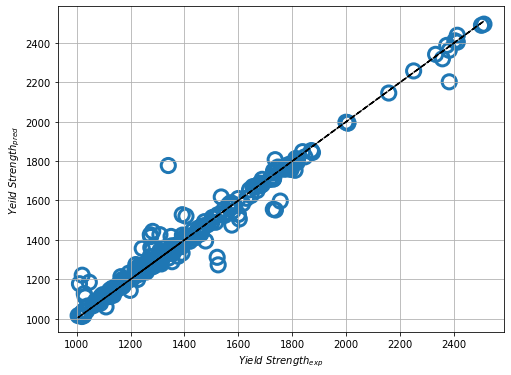

RMSE = 53.2814750991489 


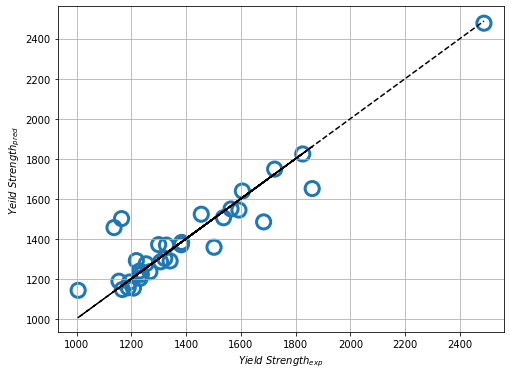

RMSE = 107.76982311178655 


In [32]:
ypred_train = model_cv['estimator'][best_estimator_id].predict(X_train)
ypred_test = model_cv['estimator'][best_estimator_id].predict(X_test)

plot_diff(y_train, ypred_train)
plot_diff(y_test, ypred_test)

# Итоги
- Исключение незначительных признаков может помочь в борьбе с переобучением: 
  - без исключения $\frac{RMSE_{test}}{RMSE_{train}} \approx 10;$
  - с исключением $\frac{RMSE_{test}}{RMSE_{train}} \approx 2.$

- Также наблюдается уменьшение $RMSE$: 
  - $RMSE_{all} = 122.93$
  - $RMSE_{significant} = 107.77$